# Common

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from typing import Optional
import pickle

def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    lambda_ : Optional[float]=None,
    beta : Optional[float]=None
):
    """
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        if beta is not None:
          with torch.no_grad():
            for name, param in model.named_parameters():
                if 'weight' in name:  # Apply only to weights, not biases
                    # Apply soft thresholding
                    param.sub_(param.sign() * LEARNING_RATE * lambda_)
                    param.data = torch.relu(param.abs() - beta * lambda_).sign() * param

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader)

def count_nonzero_params(model):
    nonzero_params = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if it's a weight parameter and exclude biases and other parameters
            if 'weight' in name:
                nonzero = torch.count_nonzero(param.data).item()
                nonzero_params[name] = nonzero
    return nonzero_params


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    PATH,
    lambda_ : Optional[float]=None,
    beta : Optional[float]=None,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    layer_nonzeros = {name: [] for name, _ in model.named_parameters() if 'weight' in name}

    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
            lambda_ = lambda_ ,
            beta = beta,
        )
        train_losses.append(train_loss)
        nonzeros = count_nonzero_params(model)
        for name in layer_nonzeros.keys():
            layer_nonzeros[name].append(nonzeros.get(name, 0))
        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")
    torch.save(model.state_dict(), '/content/ ' + PATH + '.pth')
    file = open('/content/ ' + PATH + 'losses' + '.pth','wb')
    pickle.dump({'train_losses': train_losses , 'valid_losses': valid_losses, 'valid_accs': valid_accs, 'layer_nonzeros': layer_nonzeros} , file)
    file.close()
    return train_losses, valid_losses, valid_accs, layer_nonzeros


def predict(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy


def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)


def plot_loss(losses, ylim=None):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(ylim)
    plt.title("Loss progression across epochs")

def plot_conv_filters(model):
    # Retrieve the convolutional layer's weights
    conv1_weight = model.conv1.weight.data.clone().cpu()

    # Normalize the weights
    conv1_weight = (conv1_weight - conv1_weight.min()) / (conv1_weight.max() - conv1_weight.min())

    # Get the number of filters and the number of channels
    num_filters = conv1_weight.size(0)
    num_channels = conv1_weight.size(1)
    print(num_filters)
    # Create subplots - assuming we have 3 channels (RGB)
    fig, axes = plt.subplots(4, 1)

    for i in range(4):

            # Get the filter for the ith filter and jth channel
            f = conv1_weight[i, :].permute(1,2,0)
            axes[i].imshow(f, cmap='brg')
            axes[i].axis('off')

    # Show the plot
    plt.show()


In [ ]:

class S_CONV(nn.Module):
    def __init__(self, alpha, output):
        super(S_CONV, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=alpha, kernel_size=9, stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(alpha)

        # CIFAR-10 images are 32x32, after a 9x9 convolution with stride 2 and no padding, the output size will be:
        # output size = (input size - filter size + 2 * padding) / stride + 1
        # output size = (32 - 9 + 0) / 2 + 1 = 12
        # so the output will be 12x12 feature maps per channel
        conv_output_size = alpha * 16 * 16

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 24 * alpha)
        self.bn2 = nn.BatchNorm1d(24 * alpha)
        self.fc2 = nn.Linear(24 * alpha, output)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.fc1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class S_LOCAL(nn.Module):
    def __init__(self, alpha, output):
        super(S_LOCAL, self).__init__()
        # Locally connected layer simulated by a grouped convolutional layer
        # Each input channel is connected to its own set of filters with groups which simulates locality
        self.local_conv1 = nn.Conv2d(in_channels= 3, out_channels=3*alpha, kernel_size=9, stride=2, padding=4, groups= 3)
        self.bn1 = nn.BatchNorm2d(3*alpha)

        local_conv_output_size = 3*alpha * 16 * 16

        # The rest of the fully connected layers remain the same
        self.fc1 = nn.Linear(local_conv_output_size, 24 * alpha)
        self.bn2 = nn.BatchNorm1d(24 * alpha)
        self.fc2 = nn.Linear(24 * alpha, output)

    def forward(self, x):
        x = self.local_conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.fc1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class S_FC(nn.Module):
    def __init__(self, alpha,output):
        super(S_FC, self).__init__()
        # Calculate the size of the input when flattened
        # CIFAR-10 images are 32x32 with 3 channels
        input_size = 3 * 32 * 32

        # Fully connected layers replacing the convolution
        # The input size is the flattened CIFAR-10 image size
        self.fc1 = nn.Linear(input_size, int(alpha*32*32*0.25))
        self.bn1 = nn.BatchNorm1d(int(alpha*32*32*0.25))

        # The rest of the fully connected layers remain the same
        self.fc2 = nn.Linear(int(alpha*32*32*0.25), 24 * alpha)
        self.bn2 = nn.BatchNorm1d(24 * alpha)
        self.fc3 = nn.Linear(24 * alpha, output)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor right away for fully connected layers
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
class FC_3(nn.Module):
    def __init__(self, alpha,output):
        super(FC_3, self).__init__()
        # Calculate the size of the input when flattened
        # CIFAR-10 images are 32x32 with 3 channels
        input_size = 3 * 32 * 32

        # Fully connected layers replacing the convolution
        # The input size is the flattened CIFAR-10 image size
        self.fc1 = nn.Linear(input_size, alpha)
        self.bn1 = nn.BatchNorm1d(alpha)

        # The rest of the fully connected layers remain the same
        self.fc2 = nn.Linear(alpha, alpha)
        self.fc3 = nn.Linear(alpha, output)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor right away for fully connected layers
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
# define the hyperparameters
BATCH_SIZE = 512
TEST_BATCH_SIZE = 512
LEARNING_RATE = 0.1
ALPHA = 64
##epoch size 400 or 4000
EPOCHS = 100 #400
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for Mac users with M1 chip, use this line instead
#DEVICE = torch.device("mps")
print(DEVICE)

cuda


# CIFAR10

In [ ]:
import torchvision.transforms as transforms

# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Load the CIFAR-10 dataset
# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# Access the first data sample
data_sample, label_sample = train_dataset[0]

# Print information about the dataset
print(f"Dataset size: {len(train_dataset)}")
print(f"Image size: {data_sample.size()}")
print(f"Image data type: {data_sample.dtype}")
print(f"Label: {label_sample}")
print(f"Label type: {type(label_sample)}")

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 55589617.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Dataset size: 50000
Image size: torch.Size([3, 32, 32])
Image data type: torch.float32
Label: 6
Label type: <class 'int'>
Files already downloaded and verified


In [ ]:
print(f"Dataset size: {len(test_dataset)}")

Dataset size: 10000


In [ ]:
from torch.utils.data import random_split

train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

In [ ]:
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

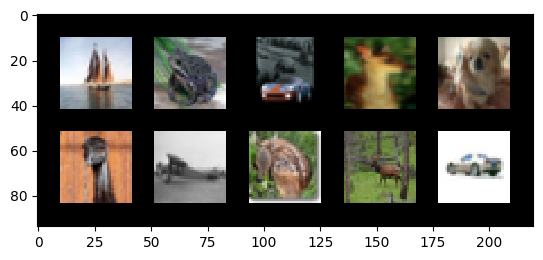

In [ ]:
visualize_images(train_dataloader)

In [ ]:
#### S_CONV SGD CIFAR10 ####

Sconv_cifar10 = S_CONV(alpha=ALPHA, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sconv_cifar10.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, layer_nonzeros = fit(model=Sconv_cifar10,
  train_dataloader=train_dataloader,valid_dataloader=valid_dataloader,
  optimizer=optimizer,epochs= EPOCHS ,device=DEVICE,PATH= 'SCONV_SGD_CIFAR10')# 4000 is too large and takes ton of time


predict(model=Sconv_cifar10, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=1.6037, Validation Loss=1.8614, Validation acc=33.6000
Epoch 1: Train Loss=1.3380, Validation Loss=2.5013, Validation acc=20.0300
Epoch 2: Train Loss=1.2020, Validation Loss=1.8520, Validation acc=36.3000
Epoch 3: Train Loss=1.0935, Validation Loss=1.9548, Validation acc=37.6200
Epoch 4: Train Loss=1.0046, Validation Loss=1.7142, Validation acc=44.2900
Test set: Avg. loss: 1.7254, Accuracy: 4393/10000 (44%)


(1.725370394897461, tensor(43.9300, device='cuda:0'))

In [ ]:
#### S_LOCAL SGD CIFAR10 ####
Slocal_cifar10 = S_LOCAL(alpha=ALPHA ,output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Slocal_cifar10.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Slocal_cifar10,
  train_dataloader=train_dataloader,valid_dataloader=valid_dataloader,
  optimizer=optimizer,epochs=EPOCHS,device=DEVICE, PATH = 'SLOC_SGD_CIFAR10')# 4000 is too large and takes ton of time


predict(model=Slocal_cifar10, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=1.6073, Validation Loss=1.6810, Validation acc=41.2900
Epoch 1: Train Loss=1.2459, Validation Loss=1.6857, Validation acc=41.5900
Epoch 2: Train Loss=1.0513, Validation Loss=3.1026, Validation acc=30.8100
Epoch 3: Train Loss=0.9041, Validation Loss=2.5076, Validation acc=37.3000
Test set: Avg. loss: 2.5412, Accuracy: 3632/10000 (36%)


(2.541154791259766, tensor(36.3200, device='cuda:0'))

In [ ]:
#### 3_FC SGD CIFAR10 ####
fc3_cifar10 = FC_3(alpha=ALPHA, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(fc3_cifar10.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs,non_zero_layers = fit(model=fc3_cifar10,
  train_dataloader=train_dataloader,valid_dataloader=valid_dataloader,
  optimizer=optimizer,epochs=EPOCHS,device=DEVICE, PATH= '3_FC_SGD_CIFAR10')# 4000 is too large and takes ton of time


predict(model=fc3_cifar10, test_dataloader=test_dataloader, device=DEVICE)

In [ ]:
#### S_FC SGD CIFAR10 ####
Sfc_cifar10 = S_FC(alpha=ALPHA, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar10.parameters(), lr=LEARNING_RATE)

beta=50
lambda_l1=2e-5
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar10,
  train_dataloader=train_dataloader,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader, PATH='S_FC_SGD_CIFAR10')# 4000 is too large and takes ton of time


predict(model=Sfc_cifar10, test_dataloader=test_dataloader, device=DEVICE)

In [ ]:
#### S_FC b=0 CIFAR10 ####
Sfc_cifar10_b0 = S_FC(alpha=ALPHA, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar10_b0.parameters(), lr=LEARNING_RATE)

beta=0
lambda_l1=2e-5
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar10_b0,
  train_dataloader=train_dataloader,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader, PATH='S_FC_b0_CIFAR10', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_cifar10_b0, test_dataloader=test_dataloader, device=DEVICE)

In [ ]:
#### S_FC b=1 CIFAR10 ####
Sfc_cifar10_b1 = S_FC(alpha=ALPHA, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar10_b1.parameters(), lr=LEARNING_RATE)

beta=1
lambda_l1=2e-5
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar10_b1,
  train_dataloader=train_dataloader,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader, PATH='S_FC_b1_CIFAR10', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_cifar10_b1, test_dataloader=test_dataloader, device=DEVICE)

In [ ]:
#### S_FC b=50 CIFAR10 ####
Sfc_cifar10_b50 = S_FC(alpha=ALPHA, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar10_b50.parameters(), lr=LEARNING_RATE)

beta=50
lambda_l1=2e-5
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar10_b50,
  train_dataloader=train_dataloader,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader, PATH='S_FC_b50_CIFAR10', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_cifar10_b50, test_dataloader=test_dataloader, device=DEVICE)

In [ ]:
model_loaded = S_LOCAL(alpha=32, output = 10).to(DEVICE)
model_loaded.load_state_dict(torch.load('/content/ dummy1.pth'))
predict(model=model_loaded, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 3.8710, Accuracy: 2846/10000 (28%)


(3.8709927734375, tensor(28.4600, device='cuda:0'))

In [ ]:
file = open('/content/ dummy1losses.pth', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()
print(data['layer_nonzeros'])

{'local_conv1.weight': [7776, 7776, 7776, 7776], 'bn1.weight': [96, 96, 96, 96], 'fc1.weight': [18874368, 18874368, 18874368, 18874368], 'bn2.weight': [768, 768, 768, 768], 'fc2.weight': [7680, 7680, 7680, 7680]}


# Cifar 100

In [ ]:
import torchvision.transforms as transforms

# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])
# Load the CIFAR-100 dataset
# load the train dataset
train_dataset100 = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# Access the first data sample
data_sample, label_sample = train_dataset100[0]

# Print information about the dataset
print(f"Dataset size: {len(train_dataset100)}")
print(f"Image size: {data_sample.size()}")
print(f"Image data type: {data_sample.dtype}")
print(f"Label: {label_sample}")
print(f"Label type: {type(label_sample)}")

# load the test dataset
test_dataset100 = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Dataset size: 50000
Image size: torch.Size([3, 32, 32])
Image data type: torch.float32
Label: 19
Label type: <class 'int'>
Files already downloaded and verified


In [ ]:
print(f"Dataset size: {len(test_dataset100)}")

Dataset size: 10000


In [ ]:
from torch.utils.data import random_split

train_dataset100,  valid_dataset100 = random_split(
    train_dataset100,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

train_dataloader100 = DataLoader(
    dataset=train_dataset100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader100 = DataLoader(
    dataset=test_dataset100,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

valid_dataloader100 = DataLoader(
    dataset=valid_dataset100,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

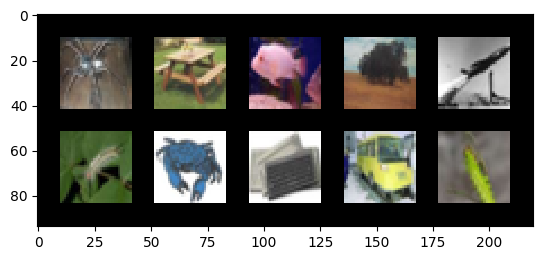

In [ ]:
visualize_images(train_dataloader100)

In [ ]:
#### S_CONV SGD CIFAR100 ####

Sconv_cifar100 = S_CONV(alpha=ALPHA, output = 100).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sconv_cifar100.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, layer_nonzeros = fit(model=Sconv_cifar100,
  train_dataloader=train_dataloader100,valid_dataloader=valid_dataloader100,
  optimizer=optimizer,epochs= EPOCHS ,device=DEVICE,PATH= 'SCONV_SGD_CIFAR100')# 4000 is too large and takes ton of time


predict(model=Sconv_cifar100, test_dataloader=test_dataloader100, device=DEVICE)

In [ ]:
#### S_LOCAL SGD CIFAR100 ####
Slocal_cifar100 = S_LOCAL(alpha=ALPHA ,output = 100).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Slocal_cifar100.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Slocal_cifar100,
  train_dataloader=train_dataloader100,valid_dataloader=valid_dataloader100,
  optimizer=optimizer,epochs=EPOCHS,device=DEVICE, PATH = 'SLOC_SGD_CIFAR100')# 4000 is too large and takes ton of time


predict(model=Slocal_cifar100, test_dataloader=test_dataloader100, device=DEVICE)

In [ ]:
#### 3_FC SGD CIFAR100 ####
fc3_cifar100 = FC_3(alpha=ALPHA, output = 100).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(fc3_cifar100.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs,non_zero_layers = fit(model=fc3_cifar100,
  train_dataloader=train_dataloader100,valid_dataloader=valid_dataloader100,
  optimizer=optimizer,epochs=EPOCHS,device=DEVICE, PATH= '3_FC_SGD_CIFAR100')# 4000 is too large and takes ton of time


predict(model=fc3_cifar100, test_dataloader=test_dataloader100, device=DEVICE)

In [ ]:
#### S_FC SGD CIFAR100 ####
ALPHA=28
Sfc_cifar100 = S_FC(alpha=ALPHA, output = 100).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar100.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar100,
  train_dataloader=train_dataloader100,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader100, PATH='S_FC_SGD_CIFAR100')# 4000 is too large and takes ton of time


predict(model=Sfc_cifar100, test_dataloader=test_dataloader100, device=DEVICE)

In [ ]:
#### S_FC b=0 CIFAR100 ####
Sfc_cifar100_b0 = S_FC(alpha=28, output = 100).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar100_b0.parameters(), lr=LEARNING_RATE)

beta=0
lambda_l1=1e-6
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar100_b0,
  train_dataloader=train_dataloader100,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader100, PATH='S_FC_b0_CIFAR100', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_cifar100_b0, test_dataloader=test_dataloader100, device=DEVICE)

In [ ]:
#### S_FC b=1 CIFAR100 ####
Sfc_cifar100_b1 = S_FC(alpha=28, output = 100).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar100_b1.parameters(), lr=LEARNING_RATE)

beta=1
lambda_l1=1e-6
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar100_b1,
  train_dataloader=train_dataloader100,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader100, PATH='S_FC_b1_CIFAR100', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_cifar100_b1, test_dataloader=test_dataloader100, device=DEVICE)

In [ ]:
#### S_FC b=50 CIFAR100 ####
Sfc_cifar100_b50 = S_FC(alpha=28, output = 100).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_cifar100_b50.parameters(), lr=LEARNING_RATE)

beta=50
lambda_l1=2e-5
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_cifar100_b50,
  train_dataloader=train_dataloader100,optimizer=optimizer,epochs=EPOCHS,
  device=DEVICE,valid_dataloader=valid_dataloader100, PATH='S_FC_b50_CIFAR100', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_cifar100_b50, test_dataloader=test_dataloader100, device=DEVICE)

#SVHN

In [ ]:
import torchvision.transforms as transforms

# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])
# Load the CIFAR-SVHN dataset
# load the train dataset
train_datasetSVHN = torchvision.datasets.SVHN(
    root='./data/',
    split='train',
    download=True,
    transform=transform)

# Access the first data sample
data_sample, label_sample = train_datasetSVHN[0]

# Print information about the dataset
print(f"Dataset size: {len(train_datasetSVHN)}")
print(f"Image size: {data_sample.size()}")
print(f"Image data type: {data_sample.dtype}")
print(f"Label: {label_sample}")
print(f"Label type: {type(label_sample)}")

# load the test dataset
test_datasetSVHN = torchvision.datasets.SVHN(
    root='./data/',
    split='test',
    download=True,
    transform=transform)

100%|██████████| 182040794/182040794 [00:28<00:00, 6357740.09it/s]


Dataset size: 73257
Image size: torch.Size([3, 32, 32])
Image data type: torch.float32
Label: 1
Label type: <class 'int'>


100%|██████████| 64275384/64275384 [00:18<00:00, 3509107.51it/s]


In [ ]:
print(f"Dataset size: {len(test_datasetSVHN)}")

Dataset size: 26032


In [ ]:
from torch.utils.data import random_split

train_datasetSVHN,  valid_datasetSVHN = random_split(
    train_datasetSVHN,
    lengths=[47225, 26032],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

train_dataloaderSVHN = DataLoader(
    dataset=train_datasetSVHN,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloaderSVHN = DataLoader(
    dataset=test_datasetSVHN,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

valid_dataloaderSVHN = DataLoader(
    dataset=valid_datasetSVHN,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

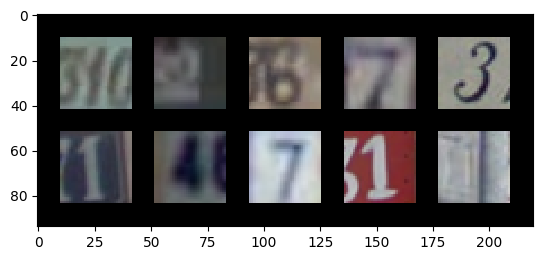

In [ ]:
visualize_images(train_dataloaderSVHN)

In [ ]:
#### S_CONV SGD SVHN ####

Sconv_SVHN = S_CONV(alpha=64, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sconv_SVHN.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, layer_nonzeros = fit(model=Sconv_SVHN,
  train_dataloader=train_dataloaderSVHN,valid_dataloader=valid_dataloaderSVHN,
  optimizer=optimizer,epochs= 400 ,device=DEVICE,PATH= 'SCONV_SGD_SVHN')# 4000 is too large and takes ton of time


predict(model=Sconv_SVHN, test_dataloader=test_dataloaderSVHN, device=DEVICE)

In [ ]:
#### S_LOCAL SGD SVHN ####
Slocal_SVHN = S_LOCAL(alpha=64 ,output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Slocal_SVHN.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Slocal_SVHN,
  train_dataloader=train_dataloaderSVHN,valid_dataloader=valid_dataloaderSVHN,
  optimizer=optimizer,epochs=400,device=DEVICE, PATH = 'SLOC_SGD_SVHN')# 4000 is too large and takes ton of time


predict(model=Slocal_SVHN, test_dataloader=test_dataloaderSVHN, device=DEVICE)

In [ ]:
#### 3_FC SGD SVHN ####
fc3_SVHN = FC_3(alpha=28, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(fc3_SVHN.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs,non_zero_layers = fit(model=fc3_SVHN,
  train_dataloader=train_dataloaderSVHN,valid_dataloader=valid_dataloaderSVHN,
  optimizer=optimizer,epochs=100,device=DEVICE, PATH= '3_FC_SGD_SVHN')# 4000 is too large and takes ton of time


predict(model=fc3_SVHN, test_dataloader=test_dataloaderSVHN, device=DEVICE)

In [ ]:
#### S_FC SGD SVHN ####
Sfc_SVHN = S_FC(alpha=28, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_SVHN.parameters(), lr=LEARNING_RATE)

# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_SVHN,
  train_dataloader=train_dataloaderSVHN,optimizer=optimizer,epochs=100,
  device=DEVICE,valid_dataloader=valid_dataloaderSVHN, PATH='S_FC_SGD_SVHN')# 4000 is too large and takes ton of time


predict(model=Sfc_SVHN, test_dataloader=test_dataloaderSVHN, device=DEVICE)

In [ ]:
#### S_FC b=0 SVHN ####
Sfc_SVHN_b0 = S_FC(alpha=28, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_SVHN_b0.parameters(), lr=LEARNING_RATE)

beta=0
lambda_l1=1e-6
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_SVHN_b0,
  train_dataloader=train_dataloaderSVHN,optimizer=optimizer,epochs=100,
  device=DEVICE,valid_dataloader=valid_dataloaderSVHN, PATH='S_FC_b0_SVHN', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_SVHN_b0, test_dataloader=test_dataloaderSVHN, device=DEVICE)

In [ ]:
#### S_FC b=1 SVHN ####
Sfc_SVHN_b1 = S_FC(alpha=28, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_SVHN_b1.parameters(), lr=LEARNING_RATE)

beta=1
lambda_l1=1e-6
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_SVHN_b1,
  train_dataloader=train_dataloaderSVHN,optimizer=optimizer,epochs=100,
  device=DEVICE,valid_dataloader=valid_dataloaderSVHN, PATH='S_FC_b1_SVHN', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_SVHN_b1, test_dataloader=test_dataloaderSVHN, device=DEVICE)

In [ ]:
#### S_FC b=50 SVHN ####
Sfc_SVHN_b50 = S_FC(alpha=28, output = 10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(Sfc_SVHN_b50.parameters(), lr=LEARNING_RATE)

beta=50
lambda_l1=1e-6
# train the NN
train_losses, valid_losses, valid_accs, non_zero_layers = fit(model=Sfc_SVHN_b50,
  train_dataloader=train_dataloaderSVHN,optimizer=optimizer,epochs=100,
  device=DEVICE,valid_dataloader=valid_dataloaderSVHN, PATH='S_FC_b50_SVHN', beta = beta, lambda_ = lambda_l1 )# 4000 is too large and takes ton of time


predict(model=Sfc_SVHN_b50, test_dataloader=test_dataloaderSVHN, device=DEVICE)